In [4]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)


In [2]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open("root_files/mc_bnb.root")[fold][tree]
nue = uproot.open("root_files/new/nue.root")[fold][tree]
data = uproot.open("root_files/bnb.root")[fold][tree]
ext = uproot.open("root_files/ext.root")[fold][tree]
dirt = uproot.open("root_files/dirt.root")[fold][tree]
lee = uproot.open("root_files/new/nue.root")[fold][tree]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trkshr_score_v", "backtracked_pdg", "shr_theta_v",
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", "trk_pfp_id",
    "shr_energy_tot", "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_cc0pinp", "nslice", "npion",
    "nproton", "nu_e", "n_showers_cc0pinp", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot"
]

mc = mc.pandas.df(variables, flatten=False)
nue = nue.pandas.df(variables + ["true_e_visible"], flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables, flatten=False)
lee = lee.pandas.df(variables + ["leeweight", "true_e_visible"], flatten=False)

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

ext["shr_dedx_Y"] = ext["shr_dedx_Y"] * 1.042
data["shr_dedx_Y"] = data["shr_dedx_Y"] * 1.042
ext["shr_energy_tot"] = ext["shr_energy_tot"] * 1.042
data["shr_energy_tot"] = data["shr_energy_tot"] * 1.042

lee["reco_e"] = (lee["shr_energy_tot"] + 0.02) / 0.8 + lee["trk_energy_tot"]
data["reco_e"] = (data["shr_energy_tot"] + 0.02) / 0.8 + data["trk_energy_tot"]
nue["reco_e"] = (nue["shr_energy_tot"] + 0.02) / 0.8 + nue["trk_energy_tot"]
mc["reco_e"] = (mc["shr_energy_tot"] + 0.02) / 0.8 + mc["trk_energy_tot"]
dirt["reco_e"] = (dirt["shr_energy_tot"] + 0.02) / 0.8 + dirt["trk_energy_tot"]
ext["reco_e"] = (ext["shr_energy_tot"] + 0.02) / 0.8 + ext["trk_energy_tot"]

data["true_e_visible"] = 0
mc["true_e_visible"] = 0
dirt["true_e_visible"] = 0
ext["true_e_visible"] = 0

lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

mc = mc.query("selected==1")
nue = nue.query("selected==1")
train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
# train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [7]:

features = nue_booster.variables.copy()
features.remove("is_signal")
features.remove("nu_e")
features.remove("train_weight")

for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    with open('pickles/booster_%s.pickle' % label, 'rb') as booster_file:
        booster = pickle.load(booster_file)
        mc[label+"_score"] = booster.predict(
            xgb.DMatrix(mc[features]),
            ntree_limit=booster.best_iteration + 1)
        nue[label+"_score"] = booster.predict(
            xgb.DMatrix(nue[features]),
            ntree_limit=booster.best_iteration + 1)
        ext[label+"_score"] = booster.predict(
            xgb.DMatrix(ext[features]),
            ntree_limit=booster.best_iteration + 1)
        data[label+"_score"] = booster.predict(
            xgb.DMatrix(data[features]),
            ntree_limit=booster.best_iteration + 1)
        dirt[label+"_score"] = booster.predict(
            xgb.DMatrix(dirt[features]),
            ntree_limit=booster.best_iteration + 1)
        lee[label+"_score"] = booster.predict(
            xgb.DMatrix(lee[features]),
            ntree_limit=booster.best_iteration + 1)
        
features = ["%s_score" % l for l in nue_booster.labels]

with open('pickles/booster.pickle', 'rb') as booster_file:
    booster = pickle.load(booster_file)
    
    mc["global_score"] = booster.predict(
        xgb.DMatrix(mc[features]),
        ntree_limit=booster.best_iteration + 1)
    nue["global_score"] = booster.predict(
        xgb.DMatrix(nue[features]),
        ntree_limit=booster.best_iteration + 1)
    ext["global_score"] = booster.predict(
        xgb.DMatrix(ext[features]),
        ntree_limit=booster.best_iteration + 1)
    data["global_score"] = booster.predict(
        xgb.DMatrix(data[features]),
        ntree_limit=booster.best_iteration + 1)
    dirt["global_score"] = booster.predict(
        xgb.DMatrix(dirt[features]),
        ntree_limit=booster.best_iteration + 1)
    lee["global_score"] = booster.predict(
        xgb.DMatrix(lee[features]),
        ntree_limit=booster.best_iteration + 1)


In [8]:
samples = {"mc": mc, "nue": nue, "data": data, "ext": ext, "dirt": dirt, "lee": lee}
weights = {"mc": 0.048277*2, "nue": 0.00060052*2, "ext": 0.698738, "dirt": 0.296018, "lee": 0.00060052}

my_plotter = plotter.Plotter(samples, weights)

5.607753347842624


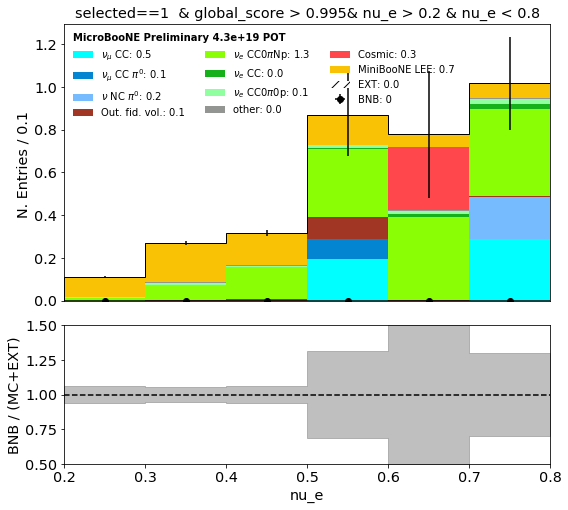

In [10]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

# print(data.query("run == 5328 & evt == 1515")[["global_score"]].to_string(index=False))6
score_cut = 0.995
fig, ax1, ax2 = my_plotter.plot_variable(
    "nu_e",
#     query="nu_e < 0.8 & reco_e < 0.8 & selected==1 & shr_energy/shr_energy_tot > 0.8 & hits_y > 100 & trk_chipr < 80 & shr_distance < 5 & trk_distance < 2.5 & selected==1 & pt/p < 0.9 & slpdg==12 & (shr_energy_tot+0.02)/0.8 > 0.06 & shr_tkfit_dedx_Y < 3.2 & shr_tkfit_dedx_Y > 0.5",
    query="selected==1  & global_score > %g" % score_cut,
    kind="event_category",
#     title=r"$dE/dx$ [MeV/cm]",
#     bins=miniboone_bins,
    bins=6,
    range=(0.2,0.8)
)
print(my_plotter.significance)
# print(lee.query("category == 111 & selected==1 & shr_tkfit_dedx_Y > 4 & shr_distance < 2.5 & nu_e < 0.3 & trk_chipr < 80 & nproton > 0")[["run", "sub", "evt", "trk_len"]].to_string(index=False))
# ax1.set_ylim(0,190)
# (0, 0.2, 0.4, 0.6, 0.9, 1.25, 1.9, 2.5)
# ax1.set_yscale("log")
# ax1.set_ylim(0,1.6)
fig.savefig("plots/spectrum.pdf")